In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten, LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Conv2D, Conv3D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.losses import binary_crossentropy
from sklearn.metrics import f1_score
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras import backend as K
from keras.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image 
import seaborn as sns
import os
import re
import glob
import cv2
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.model_selection import StratifiedKFold
from sklearn import preprocessing
import tqdm
from numpy import loadtxt
from os import *
from sklearn.utils import class_weight


Using TensorFlow backend.


In [2]:
def atoi(text):
    return int(text) if text.isdigit() else text
def natural_keys(text):
    return [atoi(c) for c in re.split('(\d+)', text)]

In [3]:
def draw_confusion_matrix(true,preds):
    conf_matx = confusion_matrix(true, preds)
    sns.heatmap(conf_matx, annot=True,annot_kws={"size": 12},fmt='g', cbar=False, cmap=plt.cm.Blues) #'viridis'
    #plt.savefig('/home/jovyan/conf_matrix.png')
    plt.show()
    
    return conf_matx

In [4]:
def plot_history(model_history, model_name):
    fig = plt.figure(figsize=(15,5), facecolor='w')
    ax = fig.add_subplot(121)
    ax.plot(model_history.history['loss'])
    ax.plot(model_history.history['val_loss'])
    ax.set(title=model_name + ': Model loss', ylabel='Loss', xlabel='Epoch')
    ax.legend(['Train', 'Val'], loc='upper left')
    ax = fig.add_subplot(122)
    ax.plot(model_history.history['accuracy'])
    ax.plot(model_history.history['val_accuracy'])
    ax.set(title=model_name + ': Model Accuracy; test='+ str(np.round(model_history.history['val_accuracy'][-1], 3)),
           ylabel='Accuracy', xlabel='Epoch')
    ax.legend(['Train', 'Val'], loc='upper left')
    #plt.savefig('/home/jovyan/curve.png')
    plt.show()
    
    return fig

In [5]:
def resize(x):
    rescaled = []

    for i in x:

        scale_percent = 140 # percent of original size
        width = int(i.shape[1] / (scale_percent / 100))
        height = int(i.shape[0] / (scale_percent / 100))
        dim = (width, height)
        resized = cv2.resize(i, dim, interpolation = cv2.INTER_LANCZOS4)
        rescaled.append(resized)

    x_orig = np.reshape( rescaled, (len( rescaled), resized.shape[1], resized.shape[1], 3))

    return x_orig

In [6]:
def loadImages(path_data):
    
    p = '/home/jovyan/DATA_MASTER_PROJECT/Check_DIFF_T0_T97/'
    
    
    
    pa_adr = p + 'ADR_cropped/'
    
    pa_control = p + 'CONTROL_cropped/'
    
    pa_hrh = p + 'HRH_cropped/'
    
    image_list = []
    
    
       


    for filename in sorted(path_data, key=natural_keys): 
        
        if 'adr' in filename:
            
            im=cv2.imread(pa_adr + filename)

            imarray = np.array(im)
            

            image_list.append(imarray)
            
        if 'control' in filename:
            
            im=cv2.imread(pa_control + filename)

            imarray = np.array(im)
            

            image_list.append(imarray)
            
        if 'hrh' in filename:
            
            im=cv2.imread(pa_hrh + filename)

            imarray = np.array(im)
            

            image_list.append(imarray)



    x_orig = np.reshape(image_list, (len(image_list), 90, 90, 3))

    return x_orig

In [7]:
def return_count(x):
    name_wel = []
    for i in sorted(x, key = natural_keys):
        name_wel.append(i.split('_')[0])

    z = sorted(list(set(name_wel)))
    r = list(range(len(z)))

    num = []
    for iz in range(len(z)):
        count = 0
        for i in sorted(x, key=natural_keys):
            if z[iz] in i:
                count += 1
        num.append(count)
    return list(zip(z, r, num))

In [8]:
def loadImages_LSTM(path_data,len_t_points):
    

    feat_list = []


    for filename in sorted(glob.glob(path_data), key=natural_keys): 
        feat_list.append(np.load(filename))

    x_orig = np.reshape(feat_list, (len(feat_list),len_t_points, 64))

    return x_orig 

In [9]:
def make_labels(data_set):
    fe = return_count(data_set)
    leb = creat_label(fe)
    y = np.array(list(leb))
    return y
    

In [10]:
def make_labels_LSTM(data_set):
    fe = return_count_LSTM(data_set)
    leb = creat_label(fe)
    y = np.array(list(leb))
    return y
    

In [11]:
def return_count_LSTM(x):
    name_wel = []
    for _,_,i in os.walk(x):
        for f in i:
            name_wel.append(f.split('_')[2])

    z = sorted(list(set(name_wel)), key=natural_keys)
    r = list(range(len(z)))

    num = []
    for iz in range(len(z)):
        count = 0
        for i in sorted(name_wel, key=natural_keys):
            if z[iz] in i:
                count += 1
        num.append(count)
    return list(zip(z, r, num))

In [12]:
def creat_label(y):
    labels = []
    for ix, _ in enumerate(y):
        
        if y[ix][0] == 'adr':
        
            labels.append([[y[ix][0],0]] * y[ix][2])
        
        if y[ix][0] == 'hrh':
            
            labels.append([[y[ix][0],1]] * y[ix][2])
        
        if y[ix][0] == 'control':
            
            labels.append([[y[ix][0],2]] * y[ix][2])
    
    ler = [i for sub in labels for i in sub ]
    
    _, lab= zip(*ler)

    
    return lab

In [13]:
def time_step_acc(tes_data, x):

    results = []            

    x_test = loadImages(tes_data)
    y_test = make_labels(tes_data)
    y_test_1 = keras.utils.to_categorical(y_test, num_classes = 3)
    x_test = resize(x_test)
    x_test = preprocess_input(x_test)

    scores = x.evaluate(x_test, y_test_1, verbose = 1)
    results.append(scores[1]*100)

    return results

In [14]:
def cv_mean_acc(result_cv, string_well):
    
    l_drug = string_well*3

    acc_mean_cv = []

    for i in result_cv:
        acc_mean_cv.append(np.mean(i))
        
    cv_drug = list(zip(acc_mean_cv, l_drug))
    
    res = sorted(cv_drug, key = lambda x: x[1])
    a , b = zip(*res)
    
    a = list(a)
    
    s = list(np.array_split(a, 5))
    
    cv_score_acc = []
    
    for ix, i in enumerate(s):
        s1 = list(s[ix])
        
        cv_score_acc.append(np.mean(s1))
        
    return list(zip(cv_score_acc, string_well))

In [15]:
# DATA FOR LSTM PART

p_feat = '/home/jovyan/DATA_MASTER_PROJECT/LSTM/F_FOLDER/'
train_data = p_feat + 'features_train/*.npy'
val_data = p_feat + 'features_validation/*.npy'
tes_data= p_feat + 'features_test/*.npy'

y_tra_path = '/home/jovyan/DATA_MASTER_PROJECT/LSTM/F_FOLDER/features_train/'
y_tes_path = '/home/jovyan/DATA_MASTER_PROJECT/LSTM/F_FOLDER/features_test/'
y_val_path = '/home/jovyan/DATA_MASTER_PROJECT/LSTM/F_FOLDER/features_validation/'

In [16]:
mid = ['C6', 'F11']
leb = ['D11', 'G4']
mep = ['F2', 'G10']
met = ['G5', 'B10']
oxy = ['G3', 'B8']

cyc = ['E4', 'G6']
dox = ['G8', 'D10']
olo = ['E7', 'B7']
ket = ['E10', 'B11']
orp = ['D8', 'B2']

In [17]:
tot_results_accuracy = []

results_lstm = []

In [18]:
tot_well_adr = [mid, leb, mep, met, oxy]
tot_well_hrh = [cyc, dox, olo, ket, orp]

string_well_adr = ['mid', 'leb', 'mep', 'met', 'oxy']
string_well_hrh = ['cyc', 'dox', 'olo', 'ket', 'orp']


In [19]:
tot_well = []
string_well = [] 

In [20]:
a = 'HRH' # FOR TEST SET
b = 'ADR' # FOR REST
c = 'CONTROL'

if a == 'HRH':
    tot_well = tot_well_hrh
    string_well = string_well_hrh
    
if a == 'ADR':
    tot_well = tot_well_adr
    string_well = string_well_adr
    

In [21]:
rand = list(np.random.randint(1,1000,3))

0it [00:00, ?it/s]
100%|██████████| 3/3 [00:14<00:00,  4.82s/it]


  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 586.0078125 steps, validate for 212.5390625 steps
Epoch 1/300
587/586 [==============================] - 22s 38ms/step - loss: 1.0784 - accuracy: 0.4553 - val_loss: 1.0705 - val_accuracy: 0.4543
Epoch 2/300
587/586 [==============================] - 18s 31ms/step - loss: 0.9994 - accuracy: 0.5032 - val_loss: 1.0603 - val_accuracy: 0.4634
Epoch 3/300
587/586 [==============================] - 18s 31ms/step - loss: 0.9721 - accuracy: 0.5262 - val_loss: 1.0508 - val_accuracy: 0.4695
Epoch 4/300
587/586 [==============================] - 18s 31ms/step - loss: 0.9540 - accuracy: 0.5411 - val_loss: 1.0521 - val_accuracy: 0.4716
Epoch 5/300
587/586 [==============================] - 18s 31ms/step - loss: 0.9399 - accuracy: 0.5511 - val_loss: 1.0524 - val_accuracy: 0.4717
Epoch 6/300
587/586 [==============================] - 19s 32ms/step - loss: 0.9279 - accuracy: 0.5595 - val_loss: 1.0580 - val_accuracy: 0.4704
Epoch 00006: early s

1it [13:41, 821.68s/it]
100%|██████████| 3/3 [00:15<00:00,  5.01s/it]


  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 586.390625 steps, validate for 223.1015625 steps
Epoch 1/300
587/586 [==============================] - 19s 33ms/step - loss: 1.0884 - accuracy: 0.4491 - val_loss: 1.1151 - val_accuracy: 0.4246
Epoch 2/300
587/586 [==============================] - 18s 30ms/step - loss: 1.0037 - accuracy: 0.4993 - val_loss: 1.0897 - val_accuracy: 0.4377
Epoch 3/300
587/586 [==============================] - 18s 30ms/step - loss: 0.9749 - accuracy: 0.5227 - val_loss: 1.0856 - val_accuracy: 0.4391
Epoch 4/300
587/586 [==============================] - 18s 30ms/step - loss: 0.9564 - accuracy: 0.5366 - val_loss: 1.0819 - val_accuracy: 0.4384
Epoch 5/300
587/586 [==============================] - 18s 31ms/step - loss: 0.9424 - accuracy: 0.5470 - val_loss: 1.0886 - val_accuracy: 0.4417
Epoch 6/300
587/586 [==============================] - 18s 31ms/step - loss: 0.9306 - accuracy: 0.5552 - val_loss: 1.0867 - val_accuracy: 0.4438
Epoch 7/300
587/586 [

2it [27:36, 825.71s/it]
100%|██████████| 3/3 [00:14<00:00,  4.76s/it]


  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 573.8046875 steps, validate for 218.3828125 steps
Epoch 1/300
574/573 [==============================] - 19s 33ms/step - loss: 1.1234 - accuracy: 0.4270 - val_loss: 1.1104 - val_accuracy: 0.4276
Epoch 2/300
574/573 [==============================] - 17s 30ms/step - loss: 1.0112 - accuracy: 0.4901 - val_loss: 1.0857 - val_accuracy: 0.4378
Epoch 3/300
574/573 [==============================] - 17s 30ms/step - loss: 0.9786 - accuracy: 0.5141 - val_loss: 1.0782 - val_accuracy: 0.4415
Epoch 4/300
574/573 [==============================] - 17s 30ms/step - loss: 0.9577 - accuracy: 0.5315 - val_loss: 1.0636 - val_accuracy: 0.4529
Epoch 5/300
574/573 [==============================] - 17s 30ms/step - loss: 0.9416 - accuracy: 0.5439 - val_loss: 1.0634 - val_accuracy: 0.4537
Epoch 6/300
574/573 [==============================] - 17s 30ms/step - loss: 0.9282 - accuracy: 0.5550 - val_loss: 1.0719 - val_accuracy: 0.4477
Epoch 7/300
574/573 

3it [41:02, 819.56s/it]
100%|██████████| 3/3 [00:14<00:00,  4.92s/it]


  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 586.7265625 steps, validate for 221.546875 steps
Epoch 1/300
587/586 [==============================] - 19s 33ms/step - loss: 1.1365 - accuracy: 0.4137 - val_loss: 1.1100 - val_accuracy: 0.4074
Epoch 2/300
587/586 [==============================] - 17s 30ms/step - loss: 1.0193 - accuracy: 0.4768 - val_loss: 1.0828 - val_accuracy: 0.4199
Epoch 3/300
587/586 [==============================] - 18s 30ms/step - loss: 0.9903 - accuracy: 0.4996 - val_loss: 1.0727 - val_accuracy: 0.4272
Epoch 4/300
587/586 [==============================] - 18s 30ms/step - loss: 0.9717 - accuracy: 0.5154 - val_loss: 1.0724 - val_accuracy: 0.4290
Epoch 5/300
587/586 [==============================] - 18s 30ms/step - loss: 0.9573 - accuracy: 0.5287 - val_loss: 1.0683 - val_accuracy: 0.4359
Epoch 6/300
587/586 [==============================] - 18s 30ms/step - loss: 0.9453 - accuracy: 0.5367 - val_loss: 1.0682 - val_accuracy: 0.4373
Epoch 7/300
587/586 [

4it [55:36, 836.07s/it]
100%|██████████| 3/3 [00:14<00:00,  4.97s/it]


  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 599.7109375 steps, validate for 212.1953125 steps
Epoch 1/300
600/599 [==============================] - 19s 32ms/step - loss: 1.1991 - accuracy: 0.4196 - val_loss: 1.0941 - val_accuracy: 0.4274
Epoch 2/300
600/599 [==============================] - 18s 30ms/step - loss: 1.0175 - accuracy: 0.4742 - val_loss: 1.0762 - val_accuracy: 0.4324
Epoch 3/300
600/599 [==============================] - 18s 29ms/step - loss: 0.9870 - accuracy: 0.4971 - val_loss: 1.0761 - val_accuracy: 0.4384
Epoch 4/300
600/599 [==============================] - 18s 30ms/step - loss: 0.9684 - accuracy: 0.5164 - val_loss: 1.0718 - val_accuracy: 0.4406
Epoch 5/300
600/599 [==============================] - 18s 30ms/step - loss: 0.9542 - accuracy: 0.5272 - val_loss: 1.0776 - val_accuracy: 0.4370
Epoch 6/300
600/599 [==============================] - 18s 30ms/step - loss: 0.9418 - accuracy: 0.5399 - val_loss: 1.0754 - val_accuracy: 0.4406
Epoch 7/300
600/599 

5it [1:08:55, 827.11s/it]
0it [00:00, ?it/s]
100%|██████████| 3/3 [00:14<00:00,  4.73s/it]


  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 618.1015625 steps, validate for 180.4453125 steps
Epoch 1/300
619/618 [==============================] - 19s 31ms/step - loss: 1.1026 - accuracy: 0.4490 - val_loss: 1.0817 - val_accuracy: 0.4395
Epoch 2/300
619/618 [==============================] - 18s 29ms/step - loss: 0.9994 - accuracy: 0.5064 - val_loss: 1.0690 - val_accuracy: 0.4455
Epoch 3/300
619/618 [==============================] - 18s 29ms/step - loss: 0.9708 - accuracy: 0.5280 - val_loss: 1.0697 - val_accuracy: 0.4417
Epoch 4/300
619/618 [==============================] - 17s 28ms/step - loss: 0.9521 - accuracy: 0.5409 - val_loss: 1.0663 - val_accuracy: 0.4469
Epoch 5/300
619/618 [==============================] - 17s 28ms/step - loss: 0.9373 - accuracy: 0.5515 - val_loss: 1.0712 - val_accuracy: 0.4546
Epoch 6/300
619/618 [==============================] - 18s 29ms/step - loss: 0.9252 - accuracy: 0.5597 - val_loss: 1.0692 - val_accuracy: 0.4536
Epoch 7/300
619/618 

1it [15:12, 912.13s/it]
100%|██████████| 3/3 [00:14<00:00,  4.88s/it]


  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 633.7890625 steps, validate for 175.703125 steps
Epoch 1/300
634/633 [==============================] - 19s 30ms/step - loss: 1.1048 - accuracy: 0.4319 - val_loss: 1.0936 - val_accuracy: 0.4304
Epoch 2/300
634/633 [==============================] - 18s 29ms/step - loss: 1.0166 - accuracy: 0.4883 - val_loss: 1.0805 - val_accuracy: 0.4393
Epoch 3/300
634/633 [==============================] - 18s 29ms/step - loss: 0.9895 - accuracy: 0.5098 - val_loss: 1.0773 - val_accuracy: 0.4432
Epoch 4/300
634/633 [==============================] - 18s 28ms/step - loss: 0.9719 - accuracy: 0.5242 - val_loss: 1.0797 - val_accuracy: 0.4406
Epoch 5/300
634/633 [==============================] - 18s 28ms/step - loss: 0.9581 - accuracy: 0.5351 - val_loss: 1.0890 - val_accuracy: 0.4355
Epoch 6/300
634/633 [==============================] - 18s 28ms/step - loss: 0.9467 - accuracy: 0.5429 - val_loss: 1.0889 - val_accuracy: 0.4322
Epoch 00006: early st

2it [30:23, 911.91s/it]
100%|██████████| 3/3 [00:14<00:00,  4.79s/it]


  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 624.1328125 steps, validate for 168.0546875 steps
Epoch 1/300
625/624 [==============================] - 18s 29ms/step - loss: 1.1008 - accuracy: 0.4339 - val_loss: 1.1093 - val_accuracy: 0.4088
Epoch 2/300
625/624 [==============================] - 17s 28ms/step - loss: 1.0013 - accuracy: 0.4964 - val_loss: 1.1102 - val_accuracy: 0.4028
Epoch 3/300
625/624 [==============================] - 17s 28ms/step - loss: 0.9723 - accuracy: 0.5206 - val_loss: 1.1125 - val_accuracy: 0.4099
Epoch 4/300
625/624 [==============================] - 17s 28ms/step - loss: 0.9532 - accuracy: 0.5357 - val_loss: 1.1060 - val_accuracy: 0.4177
Epoch 5/300
625/624 [==============================] - 18s 28ms/step - loss: 0.9382 - accuracy: 0.5483 - val_loss: 1.1123 - val_accuracy: 0.4133
Epoch 6/300
625/624 [==============================] - 17s 28ms/step - loss: 0.9261 - accuracy: 0.5576 - val_loss: 1.1080 - val_accuracy: 0.4182
Epoch 7/300
625/624 

3it [44:25, 891.00s/it]
100%|██████████| 3/3 [00:14<00:00,  4.82s/it]


  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 631.3203125 steps, validate for 176.953125 steps
Epoch 1/300
632/631 [==============================] - 19s 31ms/step - loss: 1.1018 - accuracy: 0.4193 - val_loss: 1.0932 - val_accuracy: 0.4111
Epoch 2/300
632/631 [==============================] - 18s 28ms/step - loss: 1.0122 - accuracy: 0.4826 - val_loss: 1.0930 - val_accuracy: 0.4081
Epoch 3/300
632/631 [==============================] - 18s 28ms/step - loss: 0.9860 - accuracy: 0.5058 - val_loss: 1.0882 - val_accuracy: 0.4098
Epoch 4/300
632/631 [==============================] - 18s 28ms/step - loss: 0.9683 - accuracy: 0.5216 - val_loss: 1.0943 - val_accuracy: 0.4081
Epoch 5/300
632/631 [==============================] - 18s 28ms/step - loss: 0.9550 - accuracy: 0.5319 - val_loss: 1.0935 - val_accuracy: 0.4042
Epoch 6/300
632/631 [==============================] - 18s 28ms/step - loss: 0.9434 - accuracy: 0.5409 - val_loss: 1.1087 - val_accuracy: 0.3926
Epoch 00006: early st

4it [56:53, 848.17s/it]
100%|██████████| 3/3 [00:14<00:00,  4.84s/it]


  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 628.515625 steps, validate for 183.390625 steps
Epoch 1/300
629/628 [==============================] - 19s 30ms/step - loss: 1.1308 - accuracy: 0.4074 - val_loss: 1.1249 - val_accuracy: 0.3898
Epoch 2/300
629/628 [==============================] - 18s 28ms/step - loss: 1.0168 - accuracy: 0.4803 - val_loss: 1.1088 - val_accuracy: 0.3888
Epoch 3/300
629/628 [==============================] - 18s 28ms/step - loss: 0.9898 - accuracy: 0.5020 - val_loss: 1.0957 - val_accuracy: 0.3935
Epoch 4/300
629/628 [==============================] - 18s 28ms/step - loss: 0.9724 - accuracy: 0.5156 - val_loss: 1.0921 - val_accuracy: 0.4006
Epoch 5/300
629/628 [==============================] - 18s 28ms/step - loss: 0.9586 - accuracy: 0.5266 - val_loss: 1.0997 - val_accuracy: 0.3949
Epoch 6/300
629/628 [==============================] - 18s 29ms/step - loss: 0.9468 - accuracy: 0.5351 - val_loss: 1.0998 - val_accuracy: 0.3975
Epoch 7/300
629/628 [=

5it [1:10:40, 848.08s/it]
0it [00:00, ?it/s]
100%|██████████| 3/3 [00:14<00:00,  4.76s/it]


  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 618.1015625 steps, validate for 180.4453125 steps
Epoch 1/300
619/618 [==============================] - 19s 30ms/step - loss: 1.1044 - accuracy: 0.4439 - val_loss: 1.0832 - val_accuracy: 0.4340
Epoch 2/300
619/618 [==============================] - 17s 28ms/step - loss: 1.0003 - accuracy: 0.5031 - val_loss: 1.0721 - val_accuracy: 0.4423
Epoch 3/300
619/618 [==============================] - 17s 28ms/step - loss: 0.9712 - accuracy: 0.5252 - val_loss: 1.0654 - val_accuracy: 0.4503
Epoch 4/300
619/618 [==============================] - 17s 28ms/step - loss: 0.9522 - accuracy: 0.5393 - val_loss: 1.0667 - val_accuracy: 0.4525
Epoch 5/300
619/618 [==============================] - 18s 28ms/step - loss: 0.9369 - accuracy: 0.5502 - val_loss: 1.0678 - val_accuracy: 0.4536
Epoch 6/300
619/618 [==============================] - 18s 29ms/step - loss: 0.9241 - accuracy: 0.5593 - val_loss: 1.0679 - val_accuracy: 0.4526
Epoch 00006: early s

1it [13:39, 819.09s/it]
100%|██████████| 3/3 [00:14<00:00,  4.88s/it]


  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 633.7890625 steps, validate for 175.703125 steps
Epoch 1/300
634/633 [==============================] - 19s 30ms/step - loss: 1.1359 - accuracy: 0.4195 - val_loss: 1.1112 - val_accuracy: 0.4206
Epoch 2/300
634/633 [==============================] - 18s 29ms/step - loss: 1.0143 - accuracy: 0.4899 - val_loss: 1.0997 - val_accuracy: 0.4293
Epoch 3/300
634/633 [==============================] - 18s 29ms/step - loss: 0.9856 - accuracy: 0.5123 - val_loss: 1.0893 - val_accuracy: 0.4339
Epoch 4/300
634/633 [==============================] - 18s 28ms/step - loss: 0.9673 - accuracy: 0.5259 - val_loss: 1.0971 - val_accuracy: 0.4232
Epoch 5/300
634/633 [==============================] - 18s 28ms/step - loss: 0.9533 - accuracy: 0.5373 - val_loss: 1.1111 - val_accuracy: 0.4173
Epoch 6/300
634/633 [==============================] - 18s 28ms/step - loss: 0.9417 - accuracy: 0.5457 - val_loss: 1.0990 - val_accuracy: 0.4313
Epoch 00006: early st

2it [26:05, 797.21s/it]
100%|██████████| 3/3 [00:14<00:00,  4.87s/it]


  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 624.1328125 steps, validate for 168.0546875 steps
Epoch 1/300
625/624 [==============================] - 19s 30ms/step - loss: 1.1010 - accuracy: 0.4419 - val_loss: 1.1015 - val_accuracy: 0.4234
Epoch 2/300
625/624 [==============================] - 18s 29ms/step - loss: 1.0004 - accuracy: 0.4958 - val_loss: 1.0963 - val_accuracy: 0.4235
Epoch 3/300
625/624 [==============================] - 18s 28ms/step - loss: 0.9723 - accuracy: 0.5183 - val_loss: 1.0980 - val_accuracy: 0.4201
Epoch 4/300
625/624 [==============================] - 18s 29ms/step - loss: 0.9539 - accuracy: 0.5322 - val_loss: 1.0967 - val_accuracy: 0.4266
Epoch 5/300
625/624 [==============================] - 18s 29ms/step - loss: 0.9398 - accuracy: 0.5446 - val_loss: 1.0966 - val_accuracy: 0.4239
Epoch 00005: early stopping
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 624.1328125 steps, validate for 168.0546875 steps
Epoch 1/300
625/624 [======

3it [39:00, 790.59s/it]
100%|██████████| 3/3 [00:15<00:00,  5.24s/it]


  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 631.3203125 steps, validate for 176.953125 steps
Epoch 1/300
632/631 [==============================] - 19s 30ms/step - loss: 1.1575 - accuracy: 0.4241 - val_loss: 1.0956 - val_accuracy: 0.4145
Epoch 2/300
632/631 [==============================] - 18s 29ms/step - loss: 1.0132 - accuracy: 0.4843 - val_loss: 1.0939 - val_accuracy: 0.4048
Epoch 3/300
632/631 [==============================] - 18s 29ms/step - loss: 0.9840 - accuracy: 0.5075 - val_loss: 1.0886 - val_accuracy: 0.4091
Epoch 4/300
632/631 [==============================] - 18s 29ms/step - loss: 0.9659 - accuracy: 0.5225 - val_loss: 1.0949 - val_accuracy: 0.4079
Epoch 5/300
632/631 [==============================] - 18s 29ms/step - loss: 0.9515 - accuracy: 0.5357 - val_loss: 1.0999 - val_accuracy: 0.4092
Epoch 6/300
632/631 [==============================] - 18s 29ms/step - loss: 0.9396 - accuracy: 0.5450 - val_loss: 1.1019 - val_accuracy: 0.4074
Epoch 00006: early st

4it [52:18, 792.74s/it]
100%|██████████| 3/3 [00:14<00:00,  4.87s/it]


  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 628.515625 steps, validate for 183.390625 steps
Epoch 1/300
629/628 [==============================] - 19s 30ms/step - loss: 1.1574 - accuracy: 0.4023 - val_loss: 1.1214 - val_accuracy: 0.3962
Epoch 2/300
629/628 [==============================] - 18s 29ms/step - loss: 1.0204 - accuracy: 0.4775 - val_loss: 1.0931 - val_accuracy: 0.4055
Epoch 3/300
629/628 [==============================] - 18s 29ms/step - loss: 0.9907 - accuracy: 0.5011 - val_loss: 1.0912 - val_accuracy: 0.4054
Epoch 4/300
629/628 [==============================] - 18s 29ms/step - loss: 0.9716 - accuracy: 0.5174 - val_loss: 1.0881 - val_accuracy: 0.4079
Epoch 5/300
629/628 [==============================] - 18s 29ms/step - loss: 0.9568 - accuracy: 0.5302 - val_loss: 1.0934 - val_accuracy: 0.4069
Epoch 6/300
629/628 [==============================] - 18s 29ms/step - loss: 0.9443 - accuracy: 0.5401 - val_loss: 1.0944 - val_accuracy: 0.4078
Epoch 7/300
629/628 [=

5it [1:04:56, 779.22s/it]


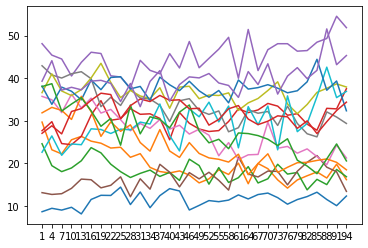

In [22]:
for num_ix, rand_num in enumerate(rand):
    for index_t_well, _ in tqdm.tqdm(enumerate(tot_well)):

        time_points = list(map(str, range(1,97,3)))

        new_time = []
        for i in time_points:
            r = '_' + i + '.'
            new_time.append(r)



        path_test = '/home/jovyan/DATA_MASTER_PROJECT/Check_DIFF_T0_T97/{}_cropped/'.format(a)

        # NAME OF THE WELLS CORRESPONDING TO THE DRUG THAT YOU WANT IN THE TEST SET 

        wells_drug = [tot_well[index_t_well][0], tot_well[index_t_well][1]] 

        test = []

        for _,_, filenames in os.walk(path_test):

            for filename in sorted(filenames, key = natural_keys):

                for w in wells_drug:
                    for t in new_time:
                        if '{}'.format(w) in filename and '{}tiff'.format(t) in filename:
                            test.append(filename)

        groups_list = ['{}'.format(a), '{}'.format(b), '{}'.format(c)]

        fileds_of_view = ['1','2','3','4']

        field_train, field_val = train_test_split(fileds_of_view, test_size=0.2, random_state=rand_num)


        train = []

        validation = []

        group_compounds = []

        for group in tqdm.tqdm(groups_list):

            pa = '/home/jovyan/DATA_MASTER_PROJECT/Check_DIFF_T0_T97/{}_cropped/'.format(group)

            for _,_, filenames in os.walk(pa):

                for filename in sorted(filenames, key = natural_keys):

                    for t in new_time:

                        if '_{}-'.format(wells_drug[0]) not in filename and '_{}-'.format(wells_drug[1]) not in filename and '{}tiff'.format(t) in filename:

                            group_compounds.append(filename)






        for i in group_compounds:

            for f in field_train:
                if '-{}_'.format(f) in i:
                    train.append(i)


            for v in field_val:
                if '-{}_'.format(v) in i:
                    validation.append(i)


        x_train = loadImages(train)
        y_train = make_labels(train)



        x_val = loadImages(validation)
        y_val = make_labels(validation)



        x_train = resize(x_train)


        x_val = resize(x_val)


        weights = class_weight.compute_class_weight('balanced', np.unique(y_train),y_train)


        x_train = preprocess_input(x_train)

        x_val = preprocess_input(x_val)


        es = EarlyStopping(monitor='val_loss', mode='min', verbose=2, patience=3)

        pretrained_model = VGG16(weights='imagenet',include_top=False, input_shape=(64, 64, 3))

        base_model = Model(inputs=pretrained_model.input, outputs=pretrained_model.get_layer('block3_pool').output)
        
        y_train = keras.utils.to_categorical(y_train)
        
        y_val = keras.utils.to_categorical(y_val)

        batch_size = 128

        datagen = ImageDataGenerator()

        datagen.fit(x_train)

        train_gen = datagen.flow(x_train, y_train,batch_size=batch_size )

        dat_val = ImageDataGenerator()

        dat_val.fit(x_val)

        val_gen = dat_val.flow(x_val, y_val,batch_size=batch_size)

        m4 = Sequential()
        m4.add(base_model)


        m4.add(BatchNormalization())
        m4.add(GlobalAveragePooling2D())
        m4.add(Dense(64, activation='relu'))
        m4.add(BatchNormalization())
        m4.add(Activation('relu'))
        m4.add(Dense(3,activation='softmax'))


        base_model.trainable = False

        opt = keras.optimizers.Adam(lr=1e-4)

        m4.compile(loss= keras.losses.categorical_crossentropy, optimizer=opt, metrics = ['accuracy'])



        epochs = 300

        m4_h = m4.fit(train_gen,
                        steps_per_epoch=(len(x_train)/batch_size),
                        callbacks = [es],
                        epochs=epochs,
                        validation_data = (val_gen), 
                        validation_steps = (len(x_val)/batch_size),
                        class_weight = weights,
                         verbose = 1)

        base_model.trainable = True

        opt = keras.optimizers.Adam(lr=1e-5)

        m4.compile(loss= keras.losses.categorical_crossentropy, optimizer=opt, metrics = ['accuracy'])

        epochs = 300

        m4_h = m4.fit(train_gen,
                        steps_per_epoch=(len(x_train)/batch_size),
                        callbacks = [es],
                        epochs=epochs,
                        validation_data = val_gen, 
                        validation_steps = (len(x_val)/batch_size),
                        class_weight = weights,
                        verbose = 1)

        l = []
        for t in new_time:
            for i in test:
                if t in i:
                    l.append((i))


        grouped = {}
        for elem in l:
            key = elem.split('.tiff')[0].split('_')[5]
            grouped.setdefault(key, []).append(elem)
        grouped = grouped.values()

        test_data = list(grouped)

        r = []

        for ix ,_ in enumerate(test_data):
            r.append(time_step_acc(test_data[ix],m4))

        plt.plot(time_points,r)
        plt.savefig('/home/jovyan/IMG_CNN_FINAL/{}_accuracy.png'.format(string_well[index_t_well]))

        tot_results_accuracy.append(r)
        
        
        # RETURN CONFUSIUON MATRIX and CLASSIFICATION REPORT
        
        # Since only one class in test set the accuracy is the F1 score
        
        
        # START LSTM PART
        
        for i, layer in enumerate(m4.layers):
            layer._name = 'layer_' + str(i)



        lstm_model = Model(inputs=m4.input, outputs=m4.get_layer('layer_4').output)
        
        del m4
        K.clear_session()

        data_name = [train,test,validation]

        feat_name = ['train', 'test', 'validation']

        for index_name, _ in enumerate(data_name):

            path =  data_name[index_name]

            name_well = []

            for i in path:
                name_well.append(i.split('_id')[0])

            wells = list(set(name_well))
            wells

            for w in wells:

                time = []


                for filename in sorted(path, key = natural_keys):
                    if w in filename: #PAY ATTENTION ID THE IMAGE IS A TIFF OR PNG IMAGE #########
                        time.append(filename)

                data_id = {}
                n_id = []
                w_n = []

                for i in time:
                    t = i.split('_id_')[1].split('time_')[0]
                    f = i.split('_id_')[0].split('time_')[0]
                    n_id.append(t)
                    w_n.append(f)

                id_cell = set(n_id)


                for ix, i in enumerate(sorted(id_cell, key = natural_keys)):

                    id_name = []
                    dict_1 = {}

                    for t in time:
                        if 'id_{}'.format(i) in t:
                            id_name.append(t)

                    d = {'id':id_name}
                    data = pd.DataFrame(d)

                    dict_1[ix]=data 
                    data_id.update(dict_1) 

                delete = [i for i, j in data_id.items() if len(j) < len(time_points)] # 9 or the length of time span you are traning on 
                for i in delete : del data_id[i]

                len_id = [i for i, j in data_id.items()]

                for le in len_id:    


                    e = pd.DataFrame(data_id[le])

                    coords = e.values.tolist()
                    id_cells = []
                    for i in coords:
                        for j in i:
                            id_cells.append(j)

                    x_orig = loadImages(id_cells)
                    x_orig = resize(x_orig)

                    x_orig = preprocess_input(x_orig)
                    output = lstm_model.predict(x_orig)
                    np.save('/home/jovyan/DATA_MASTER_PROJECT/LSTM/F_FOLDER/features_{}/features_well_{}_id_{}.npy'.format(feat_name[index_name],w_n[0], le), output)
            print('Saved_feature_{}'.format(feat_name[index_name]))


        x_train_lstm = loadImages_LSTM(train_data, len(time_points))
        y_train_lstm = make_labels_LSTM(y_tra_path)

        x_test_lstm = loadImages_LSTM(tes_data, len(time_points))
        y_test_lstm = make_labels_LSTM(y_tes_path)

        x_val_lstm = loadImages_LSTM(val_data, len(time_points))
        y_val_lstm = make_labels_LSTM(y_val_path)

        weights_lstm = class_weight.compute_class_weight('balanced', np.unique(y_train_lstm),y_train_lstm)
        
        y_train_lstm = keras.utils.to_categorical(y_train_lstm)
        y_test_1_lstm = keras.utils.to_categorical(y_test_lstm, num_classes = 3)
        y_val_lstm = keras.utils.to_categorical(y_val_lstm)


        m = Sequential()
        m.add(LSTM(32, input_shape = (x_train_lstm.shape[1],x_train_lstm.shape[2])))
        m.add(Dropout(0.2))
        m.add(Dense(3, activation='softmax'))


        opt_lstm = keras.optimizers.Adam(lr=1e-4)

        m.compile(loss= keras.losses.categorical_crossentropy, optimizer=opt, metrics = ['accuracy'])

        epochs = 300

        m_h = m.fit(x_train_lstm,y_train_lstm,

                         callbacks = [es],

                        epochs=epochs,
                        validation_data = (x_val_lstm,y_val_lstm), 

                        class_weight = weights_lstm)


        scores_lstm = m.evaluate(x_test_lstm, y_test_1_lstm)
        results_lstm.append([scores_lstm[1]*100, string_well[index_t_well]])
        
        del m
        K.clear_session()

        # DELITE FILES IN FEATURE VECTOR FOLDERS

        folders = glob.glob('/home/jovyan/DATA_MASTER_PROJECT/LSTM/F_FOLDER/*')

        for fo in folders:
            file = glob.glob(f'{fo}/*')
            for f in file:
                os.remove(f)

In [23]:
# ACCURACY SCORE AVERAGE FOR CNN
cv_s = cv_mean_acc(tot_results_accuracy, string_well)
cv_s

[(21.860280400142074, 'cyc'),
 (23.86998060780267, 'dox'),
 (32.99970218601326, 'olo'),
 (26.58591866493225, 'ket'),
 (38.28676904862126, 'orp')]

In [24]:
cv_s_mean,_ = zip(*cv_s)

m_cv = np.mean(list(cv_s_mean))
m_cv    

28.720530181502305

In [25]:
# PLOT OF MEAN ACCURACY FOR EVERY TIME POINT CNN

l_drug = string_well*3

acc_plot = []

for i in tot_results_accuracy:
    acc_plot.append(i)

cv_plot = list(zip(acc_plot, l_drug))

res_plot = sorted(cv_plot, key = lambda x: x[1])

a , b = zip(*res_plot)
    
a = list(a)

s = list(np.array_split(a, 5))

cv_plot = []

for ix, i in enumerate(s):
    s1 = list(s[ix])
    
    cv_plot.append(np.average(s1, axis=0))

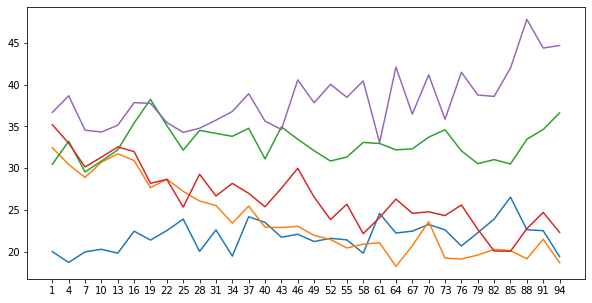

In [26]:
fig = plt.figure(figsize=(10, 5))
for i in cv_plot:
    
    plt.plot(time_points, i)
    plt.show
    plt.savefig('/home/jovyan/IMG_CNN_FINAL/cv_score.png')

In [27]:
results_lstm = sorted(results_lstm, key=lambda x: x[1])
r_lstm , _ = zip(*results_lstm)
    
r_lstm = list(r_lstm)

re_lstm = list(np.array_split(r_lstm, 5))

cv_lstm = []

for ix, i in enumerate(re_lstm):
    r1 = list(re_lstm[ix])
    cv_lstm.append(np.mean(r1))


In [28]:
cv_lstm = list(zip(cv_lstm, string_well))
cv_lstm

[(21.457489828268688, 'cyc'),
 (31.27147654692332, 'dox'),
 (37.339056531588234, 'olo'),
 (25.408804913361866, 'ket'),
 (51.269036531448364, 'orp')]

In [29]:
cv_l_mean,_ = zip(*cv_lstm)

m_cv_l = np.mean(list(cv_l_mean))
m_cv_l 

33.34917287031809

In [30]:
# BEFORE RUNNING AGAIN

folders = glob.glob('/home/jovyan/DATA_MASTER_PROJECT/LSTM/F_FOLDER/*')

for fo in folders:
    file = glob.glob(f'{fo}/*')
    for f in file:
        os.remove(f)

In [31]:
me = np.mean(cv_plot, axis = 0)
me = me.flatten()

In [32]:
sd = np.std(cv_plot, axis = 0)
sd = sd.flatten()

In [33]:
sd_cv_l =  np.std(list(cv_l_mean))
sd_cv_l

10.448148890024859

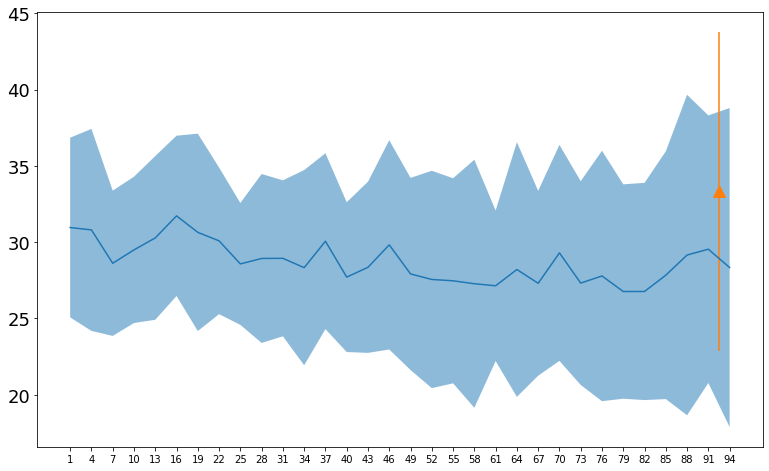

In [34]:
plt.rc('ytick', labelsize=18)
ax = plt.figure(figsize=(13,8), facecolor='w').gca()
ax.plot(me)
ax.fill_between(time_points, me - sd, me + sd, alpha = 0.5)

plt.errorbar(30.5, m_cv_l, sd_cv_l, linestyle='None', marker='^', markersize=12)

plt.savefig('/home/jovyan/md_sd_score.png')